# 07 - Scaling and Encoding

**Objetivo**: Análisis del preprocesamiento de features para modelado ML

**Contenido**:
1. Configuración
2. Carga de Datos
3. Análisis Before/After Scaling
4. Análisis de One-Hot Encoding
5. Análisis de Correlaciones
6. Validación de Splits
7. Conclusiones

## 1. Configuración

In [1]:
# Imports
import sys
sys.path.append('../..')

import json
import warnings
warnings.filterwarnings('ignore')

import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(100)

%matplotlib inline
print("✓ Librerías cargadas")

✓ Librerías cargadas


## 2. Carga de Datos

In [2]:
# Load original featured data
df_original = pl.read_parquet("../../data/processed/steel_featured.parquet")
print(f"Original data shape: {df_original.shape}")
print(f"Columns: {df_original.columns}")

Original data shape: (34910, 18)
Columns: ['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'hour', 'day_of_week', 'is_weekend', 'cyclical_hour_sin', 'cyclical_hour_cos', 'cyclical_day_sin', 'cyclical_day_cos']


In [3]:
# Load preprocessed splits
train = pl.read_parquet("../../data/processed/steel_preprocessed_train.parquet")
val = pl.read_parquet("../../data/processed/steel_preprocessed_val.parquet")
test = pl.read_parquet("../../data/processed/steel_preprocessed_test.parquet")

print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"Test shape: {test.shape}")
print(f"\nTotal rows: {len(train) + len(val) + len(test):,}")

Train shape: (24437, 10)
Val shape: (5236, 10)
Test shape: (5237, 10)

Total rows: 34,910


In [4]:
# Load preprocessing report
with open("../../reports/preprocessing_report.json", "r") as f:
    report = json.load(f)

print("Preprocessing Configuration:")
print(f"- Numeric features: {len(report['pipeline_summary']['numeric_features'])}")
print(f"- Scaled features: {len(report['pipeline_summary']['scaled_features'])}")
print(f"- Excluded from scaling: {len(report['pipeline_summary']['excluded_from_scaling'])}")
print(f"- Categorical features: {len(report['pipeline_summary']['categorical_features'])}")
print(f"- OHE output dimensions: {len(report['pipeline_summary']['ohe_features'])}")

Preprocessing Configuration:
- Numeric features: 6
- Scaled features: 6
- Excluded from scaling: 8
- Categorical features: 1
- OHE output dimensions: 2


## 3. Análisis Before/After Scaling

### 3.1 Distribuciones de Features Numéricas

In [5]:
# Features that were scaled
scaled_features = report['pipeline_summary']['scaled_features']
print(f"Features escaladas: {scaled_features}")

Features escaladas: ['NSM', 'CO2(tCO2)', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']


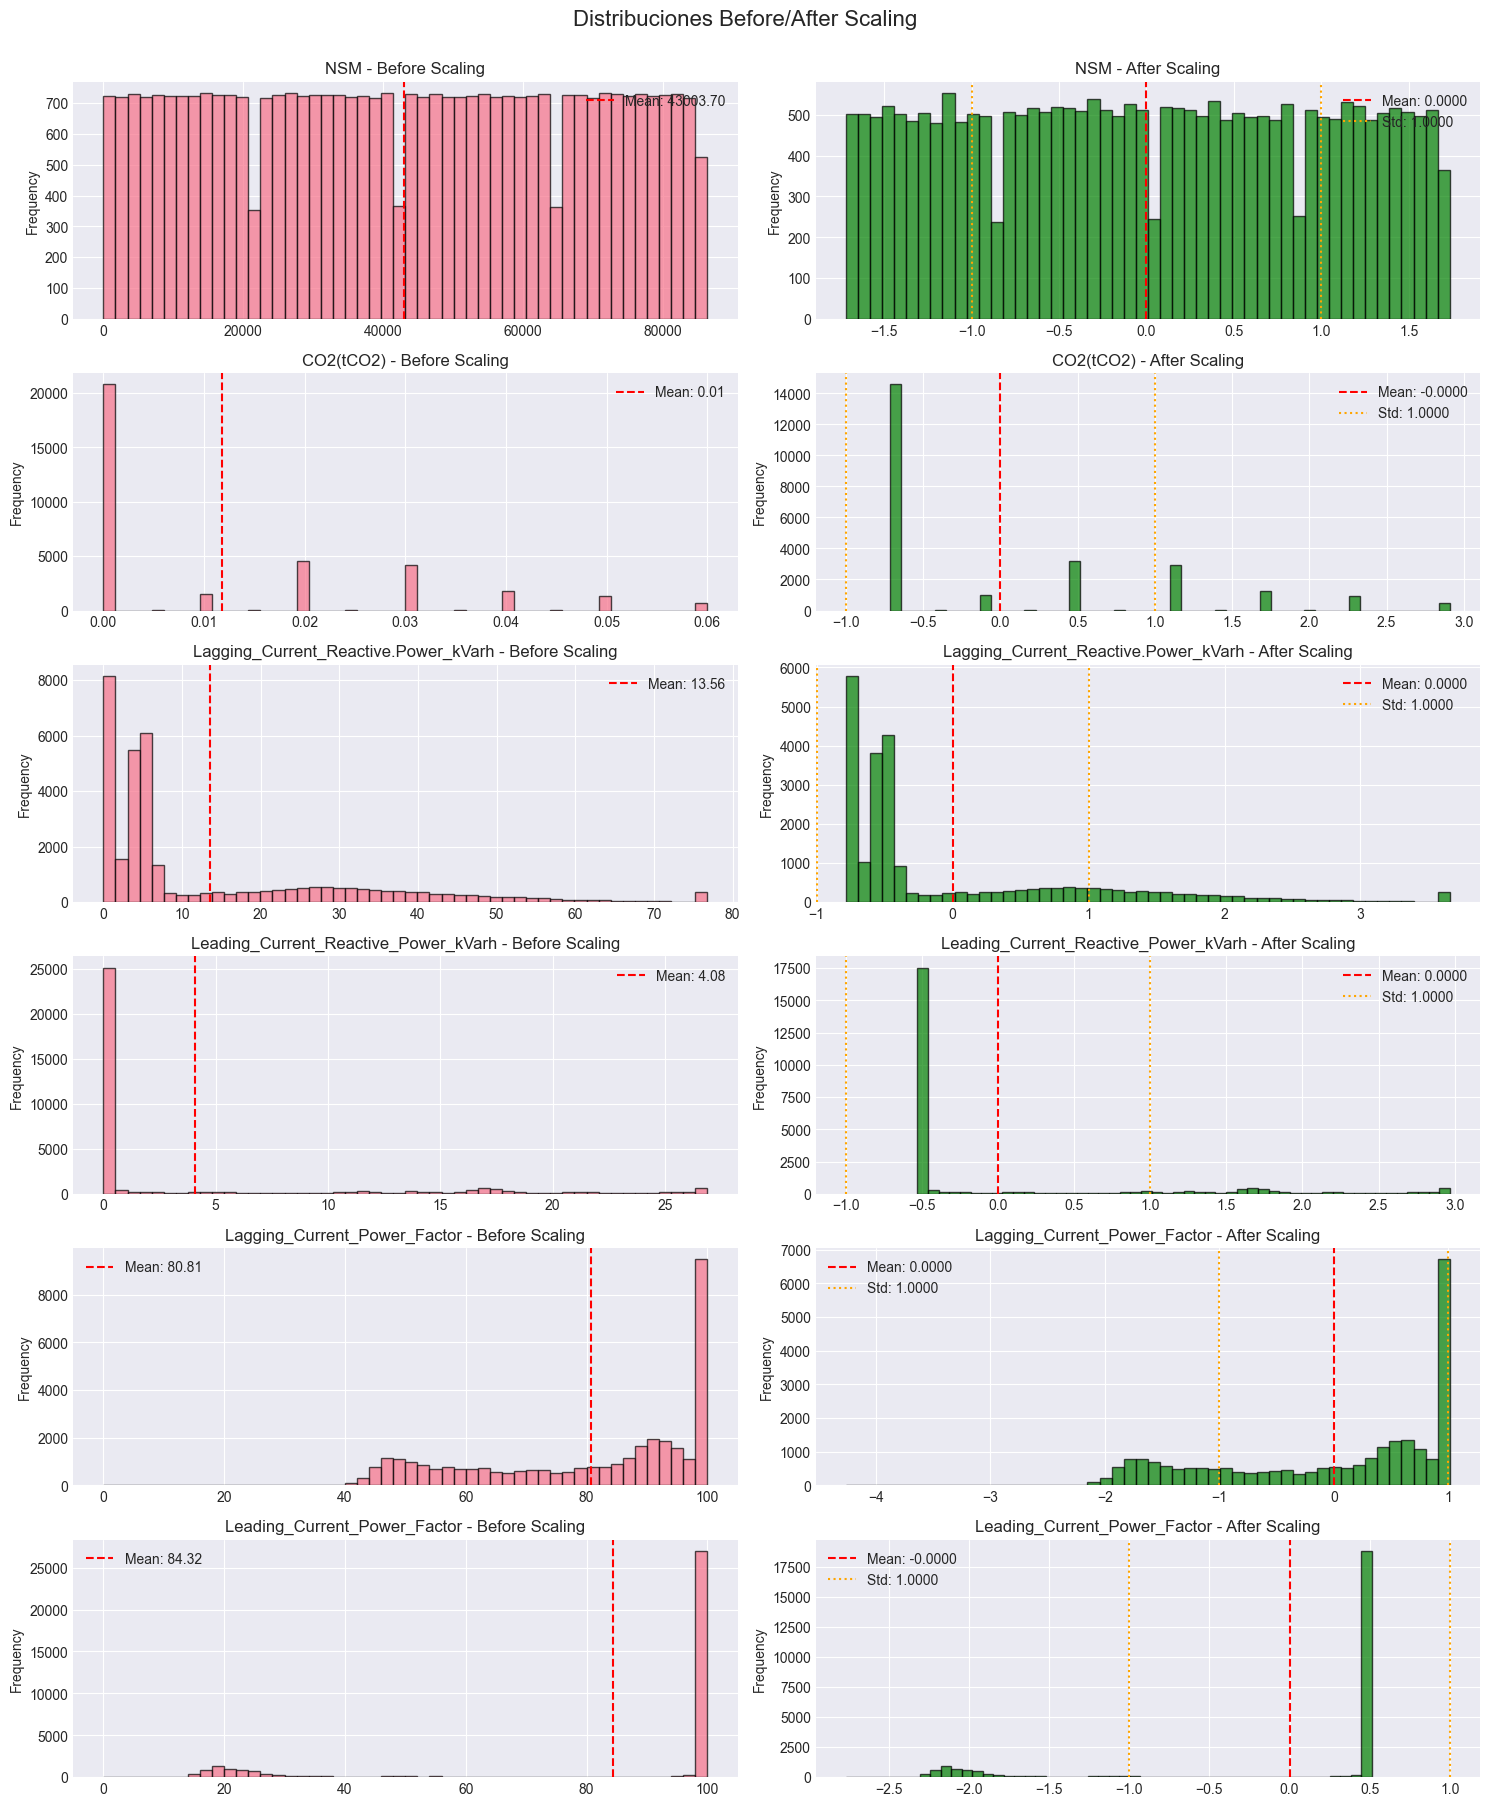

In [6]:
# Compare distributions before/after scaling
fig, axes = plt.subplots(len(scaled_features), 2, figsize=(15, len(scaled_features) * 3))
fig.suptitle('Distribuciones Before/After Scaling', fontsize=16, y=1.001)

for idx, feature in enumerate(scaled_features):
    # Before scaling (original)
    original_data = df_original.select(feature).to_numpy().flatten()
    axes[idx, 0].hist(original_data, bins=50, alpha=0.7, edgecolor='black')
    axes[idx, 0].set_title(f'{feature} - Before Scaling')
    axes[idx, 0].set_ylabel('Frequency')
    
    stats = report['pipeline_summary']['scaling_statistics'][feature]
    axes[idx, 0].axvline(stats['mean'], color='red', linestyle='--', 
                         label=f"Mean: {stats['mean']:.2f}")
    axes[idx, 0].legend()
    
    # After scaling (train)
    scaled_data = train.select(feature).to_numpy().flatten()
    axes[idx, 1].hist(scaled_data, bins=50, alpha=0.7, edgecolor='black', color='green')
    axes[idx, 1].set_title(f'{feature} - After Scaling')
    axes[idx, 1].set_ylabel('Frequency')
    
    mean_scaled = scaled_data.mean()
    std_scaled = scaled_data.std()
    axes[idx, 1].axvline(mean_scaled, color='red', linestyle='--',
                         label=f"Mean: {mean_scaled:.4f}")
    axes[idx, 1].axvline(mean_scaled + std_scaled, color='orange', linestyle=':',
                         label=f"Std: {std_scaled:.4f}")
    axes[idx, 1].axvline(mean_scaled - std_scaled, color='orange', linestyle=':')
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()


### 3.2 Validación de Escalado (Media ≈ 0, Std ≈ 1)

In [7]:
# Verify scaling statistics
scaling_validation = []

for feature in scaled_features:
    data = train.select(feature).to_numpy().flatten()
    mean = data.mean()
    std = data.std()
    
    scaling_validation.append({
        'Feature': feature,
        'Mean': f"{mean:.6f}",
        'Std': f"{std:.6f}",
        'Mean ≈ 0': "✓" if abs(mean) < 1e-10 else "✗",
        'Std ≈ 1': "✓" if abs(std - 1.0) < 0.01 else "✗"
    })

df_validation = pd.DataFrame(scaling_validation)
print("\n=== Validación de Escalado ===")
print(df_validation.to_string(index=False))


=== Validación de Escalado ===
                             Feature      Mean      Std Mean ≈ 0 Std ≈ 1
                                 NSM  0.000000 1.000000        ✓       ✓
                           CO2(tCO2) -0.000000 1.000000        ✓       ✓
Lagging_Current_Reactive.Power_kVarh  0.000000 1.000000        ✓       ✓
Leading_Current_Reactive_Power_kVarh  0.000000 1.000000        ✓       ✓
        Lagging_Current_Power_Factor  0.000000 1.000000        ✓       ✓
        Leading_Current_Power_Factor -0.000000 1.000000        ✓       ✓


### 3.3 Features Cíclicas (No Escaladas)

In [8]:
# Verify cyclical features are NOT scaled
cyclical_features = [f for f in report['pipeline_summary']['excluded_from_scaling'] 
                     if f in train.columns]

print(f"Features cíclicas (NO escaladas): {len(cyclical_features)}")
print(cyclical_features)

# Check their ranges
for feature in cyclical_features:
    data = train.select(feature).to_numpy().flatten()
    print(f"\n{feature}:")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Range: [{data.min():.2f}, {data.max():.2f}]")

Features cíclicas (NO escaladas): 0
[]


## 4. Análisis de One-Hot Encoding

### 4.1 Load_Type Encoding

In [9]:
# Check OHE columns
ohe_features = report['pipeline_summary']['ohe_features']
print(f"OHE Features: {ohe_features}")
print(f"Dimensionality: {len(ohe_features)} (original had 3 categories, drop='first')")

# Original categories
categories = report['eda']['categorical_analysis']['Load_Type']['categories']
print(f"\nOriginal categories: {categories}")
print(f"Dropped category (first): {categories[0]}")
print(f"Encoded categories: {categories[1:]}")

OHE Features: ['Load_Type_Maximum_Load', 'Load_Type_Medium_Load']
Dimensionality: 2 (original had 3 categories, drop='first')

Original categories: ['Light_Load', 'Maximum_Load', 'Medium_Load']
Dropped category (first): Light_Load
Encoded categories: ['Maximum_Load', 'Medium_Load']


In [10]:
# Verify OHE encoding
print("\n=== Distribution of OHE Features (Train) ===")
for feature in ohe_features:
    value_counts = train[feature].value_counts().sort(feature)
    print(f"\n{feature}:")
    for row in value_counts.iter_rows():
        value, count = row
        pct = count / len(train) * 100
        print(f"  {value}: {count:,} ({pct:.1f}%)")


=== Distribution of OHE Features (Train) ===

Load_Type_Maximum_Load:
  0: 19,459 (79.6%)
  1: 4,978 (20.4%)

Load_Type_Medium_Load:
  0: 17,693 (72.4%)
  1: 6,744 (27.6%)


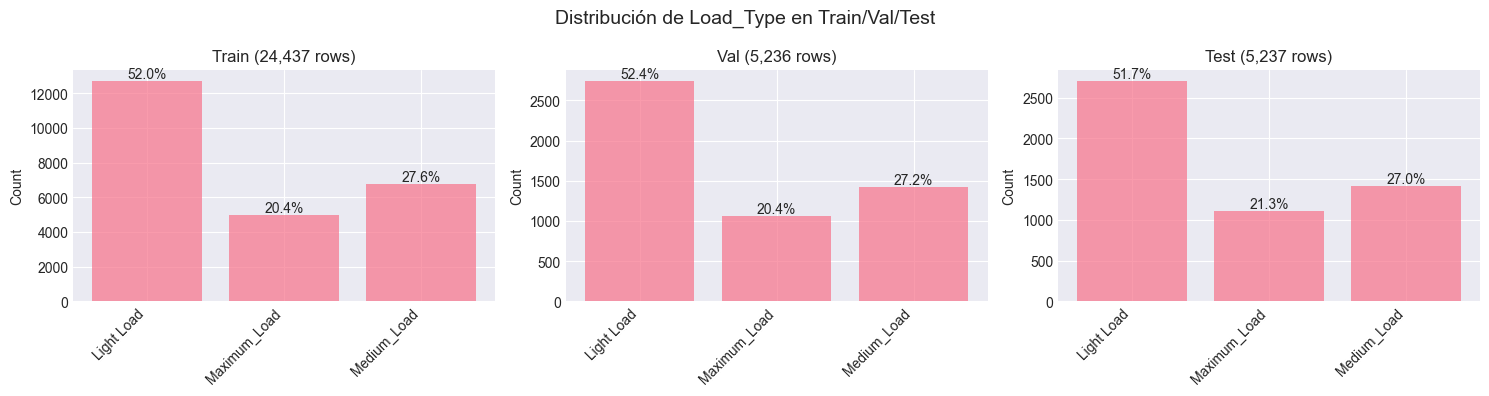

In [11]:
# Visualize OHE distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Distribución de Load_Type en Train/Val/Test', fontsize=14)

for idx, (name, df) in enumerate([('Train', train), ('Val', val), ('Test', test)]):
    # Count occurrences of each encoded category
    counts = []
    labels = []
    
    for feature in ohe_features:
        count = df[feature].sum()
        counts.append(count)
        labels.append(feature.replace('Load_Type_', ''))
    
    # Add dropped category (all zeros)
    dropped_count = len(df) - sum(counts)
    counts.insert(0, dropped_count)
    labels.insert(0, categories[0].replace('_', ' '))
    
    axes[idx].bar(range(len(counts)), counts, alpha=0.7)
    axes[idx].set_title(f'{name} ({len(df):,} rows)')
    axes[idx].set_xticks(range(len(labels)))
    axes[idx].set_xticklabels(labels, rotation=45, ha='right')
    axes[idx].set_ylabel('Count')
    
    # Add percentages
    for i, count in enumerate(counts):
        pct = count / len(df) * 100
        axes[idx].text(i, count, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### 4.2 WeekStatus Binary Encoding

In [12]:
# Check binary feature encoding
binary_features = report['pipeline_summary']['binary_features']
print(f"Binary features: {binary_features}")

if 'WeekStatus' in train.columns:
    print("\n=== WeekStatus Distribution ===")
    for name, df in [('Train', train), ('Val', val), ('Test', test)]:
        value_counts = df['WeekStatus'].value_counts().sort('WeekStatus')
        print(f"\n{name}:")
        for row in value_counts.iter_rows():
            value, count = row
            pct = count / len(df) * 100
            label = "Weekday" if value == 0 else "Weekend"
            print(f"  {value} ({label}): {count:,} ({pct:.1f}%)")

Binary features: {'WeekStatus': {'Weekday': 0, 'Weekend': 1}}

=== WeekStatus Distribution ===

Train:
  0 (Weekday): 17,533 (71.7%)
  1 (Weekend): 6,904 (28.3%)

Val:
  0 (Weekday): 3,764 (71.9%)
  1 (Weekend): 1,472 (28.1%)

Test:
  0 (Weekday): 3,780 (72.2%)
  1 (Weekend): 1,457 (27.8%)


## 5. Análisis de Correlaciones

### 5.1 Matriz de Correlación (After Preprocessing)

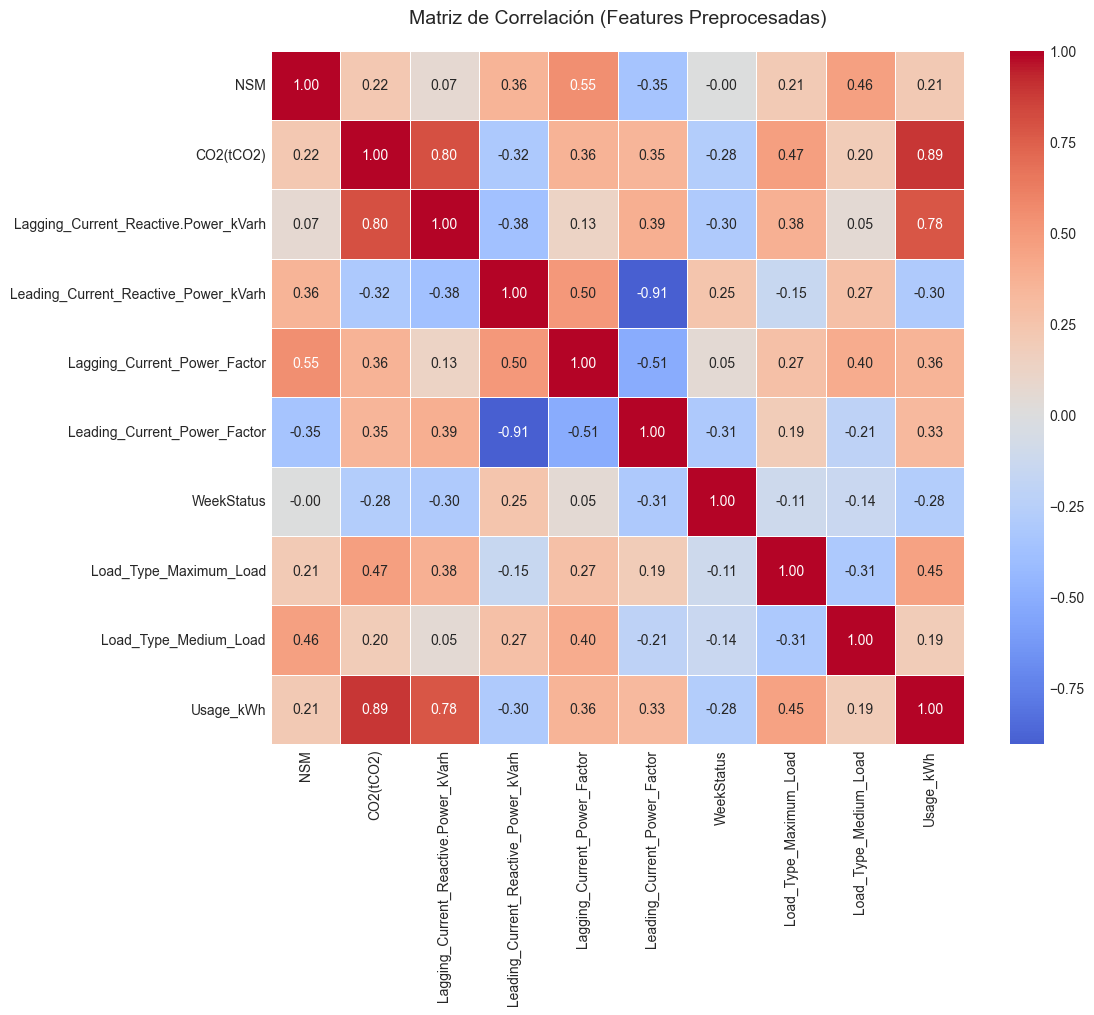

In [13]:
# Calculate correlation matrix
train_pd = train.to_pandas()
corr_matrix = train_pd.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Matriz de Correlación (Features Preprocesadas)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

In [14]:
# Top correlations with target
target_corr = corr_matrix['Usage_kWh'].sort_values(ascending=False)
print("=== Top Correlaciones con Usage_kWh ===")
print(target_corr)

=== Top Correlaciones con Usage_kWh ===
Usage_kWh                               1.000000
CO2(tCO2)                               0.892256
Lagging_Current_Reactive.Power_kVarh    0.779016
Load_Type_Maximum_Load                  0.451426
Lagging_Current_Power_Factor            0.356116
Leading_Current_Power_Factor            0.329401
NSM                                     0.213618
Load_Type_Medium_Load                   0.193006
WeekStatus                             -0.278035
Leading_Current_Reactive_Power_kVarh   -0.296191
Name: Usage_kWh, dtype: float64


### 5.2 Multicolinealidad

In [15]:
# Check for multicollinearity (high correlations between features)
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:  # Threshold
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': f"{corr_value:.3f}"
            })

if high_corr_pairs:
    print("\n=== Pares con Alta Correlación (|r| > 0.8) ===")
    df_high_corr = pd.DataFrame(high_corr_pairs)
    print(df_high_corr.to_string(index=False))
else:
    print("\n✓ No se detectaron pares con correlación > 0.8")


=== Pares con Alta Correlación (|r| > 0.8) ===
                           Feature 1                            Feature 2 Correlation
                           CO2(tCO2) Lagging_Current_Reactive.Power_kVarh       0.802
                           CO2(tCO2)                            Usage_kWh       0.892
Leading_Current_Reactive_Power_kVarh         Leading_Current_Power_Factor      -0.907


## 6. Validación de Splits

### 6.1 Distribución del Target

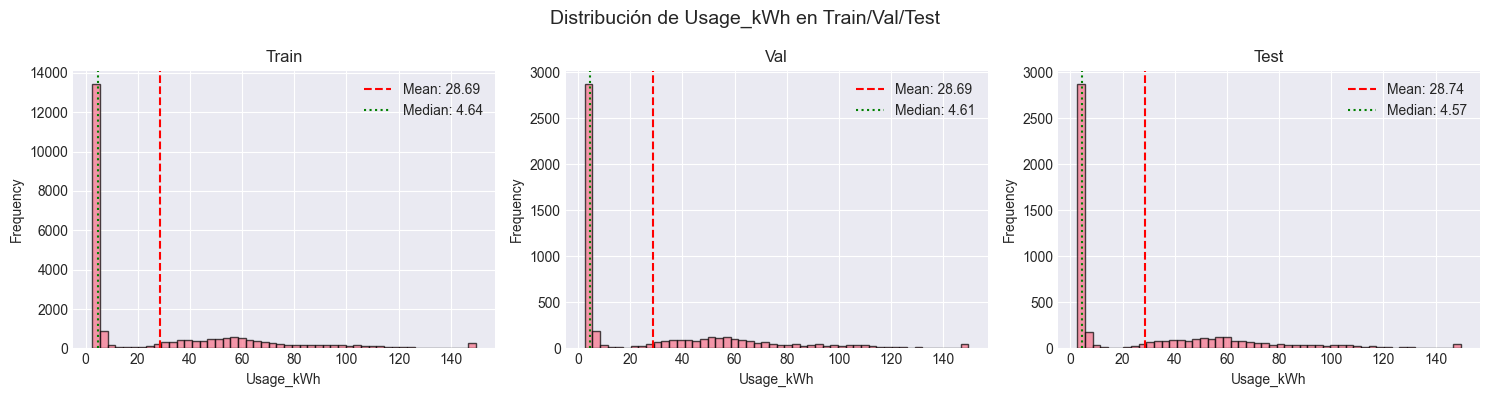

In [16]:
# Compare target distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Distribución de Usage_kWh en Train/Val/Test', fontsize=14)

for idx, (name, df) in enumerate([('Train', train), ('Val', val), ('Test', test)]):
    data = df['Usage_kWh'].to_numpy()
    
    axes[idx].hist(data, bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Usage_kWh')
    axes[idx].set_ylabel('Frequency')
    
    # Add statistics
    mean = data.mean()
    median = np.median(data)
    axes[idx].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    axes[idx].axvline(median, color='green', linestyle=':', label=f'Median: {median:.2f}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [17]:
# Statistical comparison
target_stats = []
for name, df in [('Train', train), ('Val', val), ('Test', test)]:
    data = df['Usage_kWh'].to_numpy()
    target_stats.append({
        'Split': name,
        'Count': f"{len(data):,}",
        'Mean': f"{data.mean():.2f}",
        'Std': f"{data.std():.2f}",
        'Min': f"{data.min():.2f}",
        'Max': f"{data.max():.2f}",
        'Median': f"{np.median(data):.2f}"
    })

df_stats = pd.DataFrame(target_stats)
print("\n=== Estadísticas del Target por Split ===")
print(df_stats.to_string(index=False))


=== Estadísticas del Target por Split ===
Split  Count  Mean   Std  Min    Max Median
Train 24,437 28.69 35.50 2.59 149.65   4.64
  Val  5,236 28.69 35.50 2.59 149.65   4.61
 Test  5,237 28.74 35.52 2.59 149.65   4.57


### 6.2 Box Plots

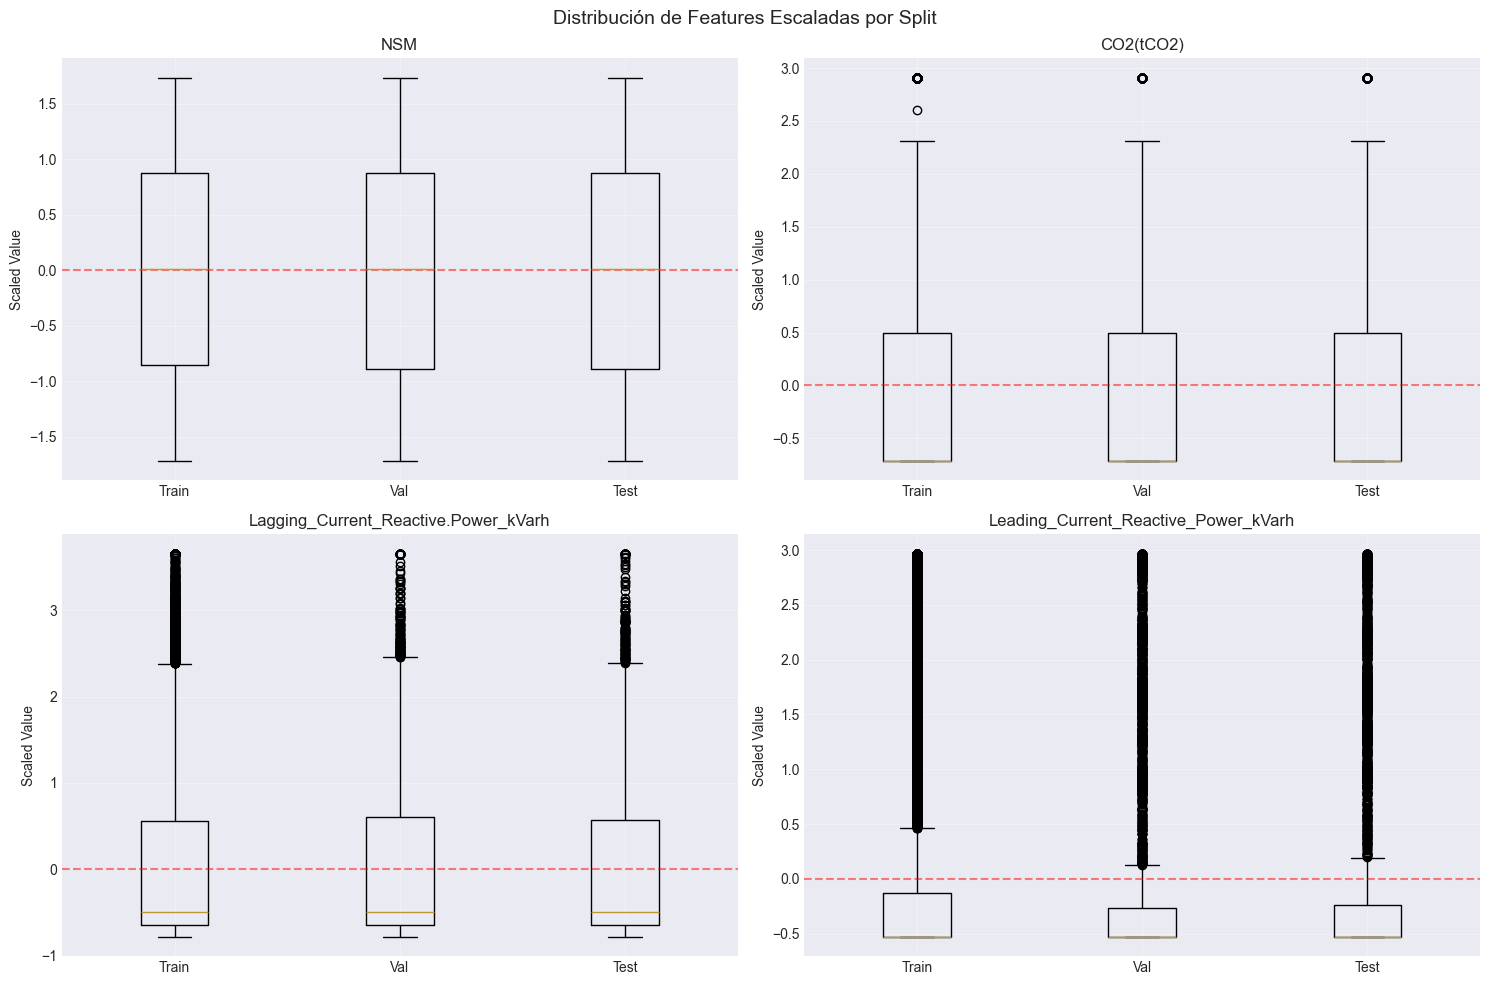

In [18]:
# Box plots for numeric features
numeric_features_to_plot = scaled_features[:4]  # First 4 scaled features

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
fig.suptitle('Distribución de Features Escaladas por Split', fontsize=14)

for idx, feature in enumerate(numeric_features_to_plot):
    data_to_plot = [
        train[feature].to_numpy(),
        val[feature].to_numpy(),
        test[feature].to_numpy()
    ]
    
    axes[idx].boxplot(data_to_plot, labels=['Train', 'Val', 'Test'])
    axes[idx].set_title(feature)
    axes[idx].set_ylabel('Scaled Value')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Resumen y Conclusiones

In [20]:
print("RESUMEN - US-012 SCALING AND ENCODING")

print("\n1. DATASETS GENERADOS:")
print(f"   - Train: {len(train):,} rows ({len(train)/(len(train)+len(val)+len(test))*100:.1f}%)")
print(f"   - Val: {len(val):,} rows ({len(val)/(len(train)+len(val)+len(test))*100:.1f}%)")
print(f"   - Test: {len(test):,} rows ({len(test)/(len(train)+len(val)+len(test))*100:.1f}%)")
print(f"   - Total: {len(train)+len(val)+len(test):,} rows")

print("\n2. DIMENSIONALIDAD:")
print(f"   - Input features: {report['pipeline_summary']['n_features_in']}")
print(f"   - Output features: {report['pipeline_summary']['n_features_out']}")
print(f"   - Reducción: {report['pipeline_summary']['n_features_in'] - report['pipeline_summary']['n_features_out']} features")

print("\n3. SCALING:")
print(f"   - Features escaladas: {len(scaled_features)}")
print(f"   - Features excluidas (cíclicas): {len(report['pipeline_summary']['excluded_from_scaling'])}")
print(f"   - Método: StandardScaler (mean=0, std=1)")

# Verify scaling
all_scaled_ok = True
for feature in scaled_features:
    data = train[feature].to_numpy()
    if abs(data.mean()) > 1e-10 or abs(data.std() - 1.0) > 0.01:
        all_scaled_ok = False
        break

print(f"   - Validación: {'✓ PASSED' if all_scaled_ok else '✗ FAILED'}")

print("\n4. ENCODING:")
print(f"   - Categorical features: {len(report['pipeline_summary']['categorical_features'])}")
print(f"   - OHE dimensions: {len(report['pipeline_summary']['ohe_features'])} (drop='first')")
print(f"   - Binary features: {len(report['pipeline_summary']['binary_features'])}")

print("\n5. MULTICOLINEALIDAD:")
if high_corr_pairs:
    print(f"   - Pares con |r| > 0.8: {len(high_corr_pairs)}")
else:
    print("   - ✓ No se detectó multicolinealidad alta")

print("\n6. DISTRIBUCIÓN DEL TARGET:")
train_mean = train['Usage_kWh'].mean()
val_mean = val['Usage_kWh'].mean()
test_mean = test['Usage_kWh'].mean()
print(f"   - Train mean: {train_mean:.2f}")
print(f"   - Val mean: {val_mean:.2f} (diff: {abs(val_mean-train_mean)/train_mean*100:.2f}%)")
print(f"   - Test mean: {test_mean:.2f} (diff: {abs(test_mean-train_mean)/train_mean*100:.2f}%)")

print("\n" + "="*80)
print("✓ ANÁLISIS COMPLETADO")
print("="*80)

RESUMEN - US-012 SCALING AND ENCODING

1. DATASETS GENERADOS:
   - Train: 24,437 rows (70.0%)
   - Val: 5,236 rows (15.0%)
   - Test: 5,237 rows (15.0%)
   - Total: 34,910 rows

2. DIMENSIONALIDAD:
   - Input features: 18
   - Output features: 9
   - Reducción: 9 features

3. SCALING:
   - Features escaladas: 6
   - Features excluidas (cíclicas): 8
   - Método: StandardScaler (mean=0, std=1)
   - Validación: ✓ PASSED

4. ENCODING:
   - Categorical features: 1
   - OHE dimensions: 2 (drop='first')
   - Binary features: 1

5. MULTICOLINEALIDAD:
   - Pares con |r| > 0.8: 3

6. DISTRIBUCIÓN DEL TARGET:
   - Train mean: 28.69
   - Val mean: 28.69 (diff: 0.00%)
   - Test mean: 28.74 (diff: 0.18%)

✓ ANÁLISIS COMPLETADO


### Conclusiones Clave

1. **Escalado Exitoso**: Todas las features numéricas fueron escaladas correctamente con mean ≈ 0 y std ≈ 1

2. **Features Cíclicas Preservadas**: Las 8 features cíclicas (sin, cos) se mantuvieron sin escalar en el rango [-1, 1]

3. **One-Hot Encoding**: Load_Type se codificó correctamente con 2 dimensiones (drop='first' para evitar multicolinealidad)

4. **Binary Encoding**: WeekStatus se mapeó a 0/1 (más eficiente que OHE)

5. **Distribuciones Consistentes**: Las distribuciones del target son similares en train/val/test (estratificación exitosa)

6. **Datos Listos para Modelado**: Los datasets preprocesados están listos para entrenar modelos de ML

